<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session13/ViT_Cats_n_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vit-pytorch linformer

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

In [3]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [4]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile

In [5]:
from sklearn.model_selection import train_test_split 

In [6]:
batch_size = 64
epochs = 50
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

#Get the dataset from Kaggle

In [7]:
! pip install -q kaggle

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mittalneha","key":"65e70efef2baf98548a6f0949708be30"}'}

In [9]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100% 271M/271M [00:01<00:00, 223MB/s]
100% 271M/271M [00:01<00:00, 215MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 100MB/s]
 98% 530M/544M [00:06<00:00, 92.8MB/s]
100% 544M/544M [00:06<00:00, 86.6MB/s]


In [11]:
!kaggle -v

Kaggle API 1.5.4


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("CUDA Available:", use_cuda)
print("Selected Device:", device)
seed = 1
# For reproducibility
torch.manual_seed(seed)

# if use_cuda:
#     torch.cuda.manual_seed(seed)
#     BATCH_SIZE=256
# else:
#     BATCH_SIZE=32
# print("Batch Size", BATCH_SIZE)

CUDA Available: True
Selected Device: cuda


#Load Data

In [13]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [14]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

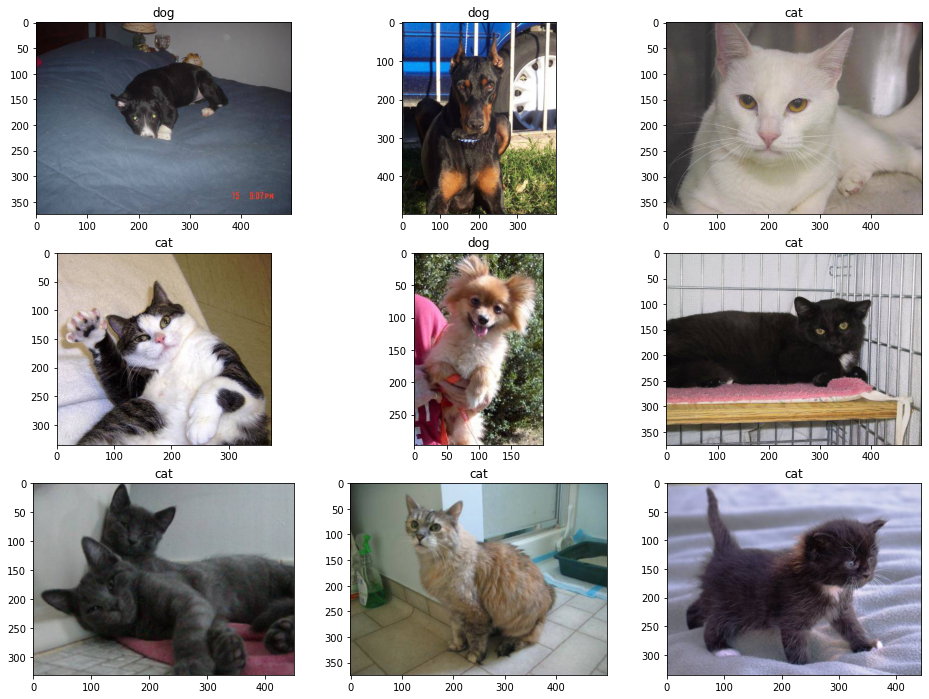

In [15]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [16]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [17]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [18]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

#defining train, validation and test dataset

In [19]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [20]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [21]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

#Visual transformer 

In [22]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
history = [[0]*5]*epochs

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    history[epoch] = [epoch, epoch_loss.item(), epoch_accuracy.item(), epoch_val_loss.item(), epoch_val_accuracy.item()]


Epoch : 1 - loss : 0.6951 - acc: 0.5059 - val_loss : 0.6911 - val_acc: 0.5162




Epoch : 2 - loss : 0.6911 - acc: 0.5231 - val_loss : 0.6941 - val_acc: 0.5174




Epoch : 3 - loss : 0.6871 - acc: 0.5401 - val_loss : 0.6852 - val_acc: 0.5386




Epoch : 4 - loss : 0.6807 - acc: 0.5584 - val_loss : 0.6712 - val_acc: 0.5839




Epoch : 5 - loss : 0.6738 - acc: 0.5807 - val_loss : 0.6711 - val_acc: 0.5825




Epoch : 6 - loss : 0.6662 - acc: 0.5903 - val_loss : 0.6511 - val_acc: 0.6052




Epoch : 7 - loss : 0.6520 - acc: 0.6024 - val_loss : 0.6491 - val_acc: 0.6167




Epoch : 8 - loss : 0.6453 - acc: 0.6162 - val_loss : 0.6373 - val_acc: 0.6206




Epoch : 9 - loss : 0.6417 - acc: 0.6253 - val_loss : 0.6323 - val_acc: 0.6284




Epoch : 10 - loss : 0.6348 - acc: 0.6310 - val_loss : 0.6265 - val_acc: 0.6343




Epoch : 11 - loss : 0.6248 - acc: 0.6447 - val_loss : 0.6216 - val_acc: 0.6501




Epoch : 12 - loss : 0.6189 - acc: 0.6497 - val_loss : 0.6042 - val_acc: 0.6630




Epoch : 13 - loss : 0.6171 - acc: 0.6494 - val_loss : 0.6080 - val_acc: 0.6644




Epoch : 14 - loss : 0.6085 - acc: 0.6569 - val_loss : 0.6039 - val_acc: 0.6707




Epoch : 15 - loss : 0.6061 - acc: 0.6614 - val_loss : 0.5953 - val_acc: 0.6744




Epoch : 16 - loss : 0.6036 - acc: 0.6688 - val_loss : 0.5940 - val_acc: 0.6721




Epoch : 17 - loss : 0.5913 - acc: 0.6786 - val_loss : 0.5890 - val_acc: 0.6814




Epoch : 18 - loss : 0.5915 - acc: 0.6794 - val_loss : 0.5875 - val_acc: 0.6804




Epoch : 19 - loss : 0.5873 - acc: 0.6832 - val_loss : 0.5871 - val_acc: 0.6847




Epoch : 20 - loss : 0.5881 - acc: 0.6830 - val_loss : 0.5829 - val_acc: 0.6887




Epoch : 21 - loss : 0.5839 - acc: 0.6841 - val_loss : 0.5816 - val_acc: 0.6895




Epoch : 22 - loss : 0.5849 - acc: 0.6856 - val_loss : 0.5801 - val_acc: 0.6946




Epoch : 23 - loss : 0.5806 - acc: 0.6901 - val_loss : 0.5824 - val_acc: 0.6907




Epoch : 24 - loss : 0.5782 - acc: 0.6939 - val_loss : 0.5723 - val_acc: 0.7077




Epoch : 25 - loss : 0.5779 - acc: 0.6933 - val_loss : 0.5793 - val_acc: 0.6934




Epoch : 26 - loss : 0.5736 - acc: 0.6969 - val_loss : 0.5745 - val_acc: 0.6982




Epoch : 27 - loss : 0.5720 - acc: 0.6979 - val_loss : 0.5678 - val_acc: 0.7053




Epoch : 28 - loss : 0.5694 - acc: 0.6967 - val_loss : 0.5743 - val_acc: 0.6936




Epoch : 29 - loss : 0.5656 - acc: 0.7010 - val_loss : 0.5596 - val_acc: 0.7065




Epoch : 30 - loss : 0.5706 - acc: 0.6973 - val_loss : 0.5640 - val_acc: 0.6952




Epoch : 31 - loss : 0.5656 - acc: 0.7043 - val_loss : 0.5740 - val_acc: 0.6996




Epoch : 32 - loss : 0.5642 - acc: 0.7009 - val_loss : 0.5700 - val_acc: 0.7073




Epoch : 33 - loss : 0.5644 - acc: 0.7048 - val_loss : 0.5777 - val_acc: 0.6911




Epoch : 34 - loss : 0.5641 - acc: 0.7038 - val_loss : 0.5628 - val_acc: 0.7039




Epoch : 35 - loss : 0.5672 - acc: 0.6989 - val_loss : 0.5620 - val_acc: 0.7069




Epoch : 36 - loss : 0.5562 - acc: 0.7103 - val_loss : 0.5614 - val_acc: 0.7061




Epoch : 37 - loss : 0.5602 - acc: 0.7067 - val_loss : 0.5590 - val_acc: 0.7138




Epoch : 38 - loss : 0.5569 - acc: 0.7092 - val_loss : 0.5567 - val_acc: 0.7144




Epoch : 39 - loss : 0.5560 - acc: 0.7076 - val_loss : 0.5537 - val_acc: 0.7184




Epoch : 40 - loss : 0.5566 - acc: 0.7110 - val_loss : 0.5606 - val_acc: 0.7134




Epoch : 41 - loss : 0.5553 - acc: 0.7076 - val_loss : 0.5655 - val_acc: 0.7004




Epoch : 42 - loss : 0.5533 - acc: 0.7134 - val_loss : 0.5539 - val_acc: 0.7110




Epoch : 43 - loss : 0.5528 - acc: 0.7107 - val_loss : 0.5541 - val_acc: 0.7059




Epoch : 44 - loss : 0.5492 - acc: 0.7159 - val_loss : 0.5623 - val_acc: 0.7087




Epoch : 45 - loss : 0.5504 - acc: 0.7153 - val_loss : 0.5532 - val_acc: 0.7093




Epoch : 46 - loss : 0.5493 - acc: 0.7150 - val_loss : 0.5666 - val_acc: 0.7071




Epoch : 47 - loss : 0.5502 - acc: 0.7139 - val_loss : 0.5610 - val_acc: 0.7063




Epoch : 48 - loss : 0.5479 - acc: 0.7131 - val_loss : 0.5529 - val_acc: 0.7156




Epoch : 49 - loss : 0.5466 - acc: 0.7155 - val_loss : 0.5531 - val_acc: 0.7150




Epoch : 50 - loss : 0.5467 - acc: 0.7163 - val_loss : 0.5556 - val_acc: 0.7100



In [24]:
his = history

In [25]:
for r in range(len(history)):
    for c in range(len(history[0])):
        if type(history[r][c]) == torch.Tensor:
            history[r][c] = history[r][c].item()

In [26]:
history = np.array(history).transpose(1,0)

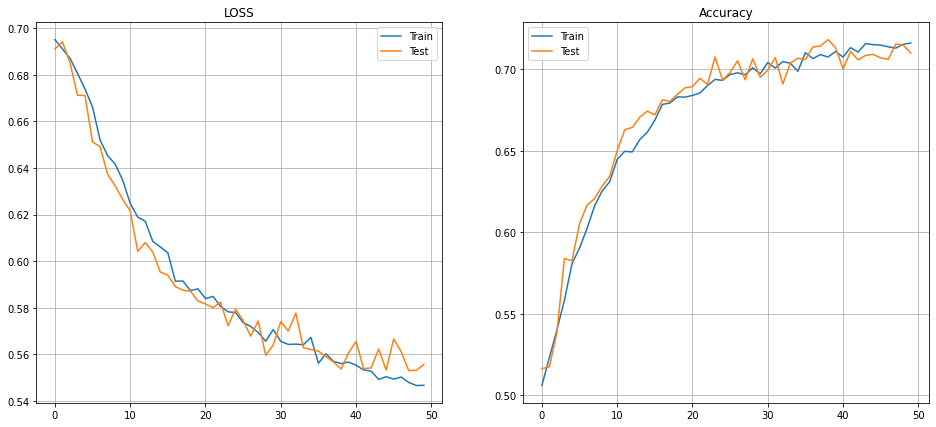

In [27]:

fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history[1], label='Train')
axs[0].plot(history[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history[2], label='Train')
axs[1].plot(history[4], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

In [28]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [29]:
torch.save(model.state_dict(),"/gdrive/MyDrive/EVA6/ViT/model_20.pt")

In [49]:
# model_path = '/gdrive/MyDrive/EVA6/ViT/model_{epoch}.pt'
# model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [34]:
classes = ['cat', 'dog']

#Run the model on some test images

Text(0.5, 1.0, 'Pred label: cat')

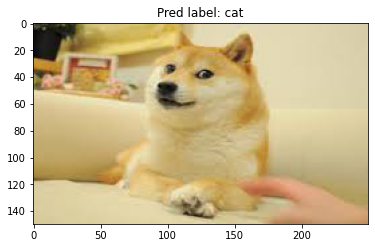

In [56]:
img1 = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (1).jpeg")
x = test_transforms(img1)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img1, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: dog')

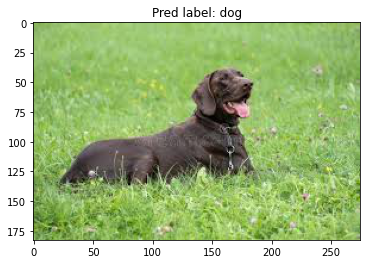

In [42]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/images (3).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: cat')

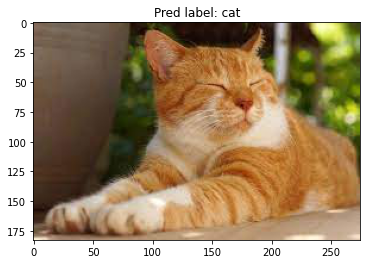

In [39]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (2).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: cat')

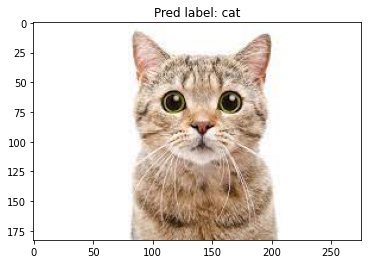

In [40]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (3).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

Text(0.5, 1.0, 'Pred label: dog')

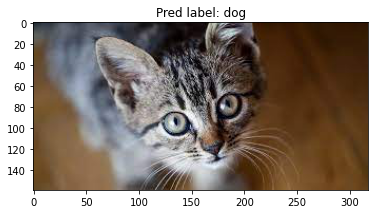

In [57]:
img = Image.open("/gdrive/MyDrive/EVA6/ViT/test_images/download (4).jpeg")
x = test_transforms(img)
pred = model(x.unsqueeze(0).to(device))
plt.imshow(img, cmap="gray")
plt.title(f"Pred label: {classes[pred.argmax().item()]}")

In [59]:
pred


tensor([[-0.2964,  0.1938]], device='cuda:0', grad_fn=<AddmmBackward>)